
# Slim simulations



In [1]:
import re, os, sys, pickle, pickle, math
from pathlib import Path
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from GenomicWindows import window
import GenomicIntervals

np.random.seed(7)

Import variables global to the entire analysis:

In [2]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [3]:
if str(ag.scripts_dir) not in sys.path:
    sys.path.append(str(ag.scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

Plotting setup:

In [4]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # seaborn niceness
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

Ignore warnings:

In [5]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Load meta data

Easy loading of meta data in a consistent manner across code

In [6]:
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=ag.meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Compute demographies

In [7]:
sim_generations = 100000 - 1
x_auto_fraction = 0.55

def years2gen(y):
    return int(1 + sim_generations - y / ag.gen_time)

years2gen(sim_generations * ag.gen_time), years2gen(0), sim_generations * ag.gen_time

(1, 100000, 2899971)

In [8]:
changes_year = [sim_generations * ag.gen_time, 250000, 150000, 100000, 70000, 50000, 35000, 25000, 15000, 6000]
changes_Ne = [20000, 12000, 6000, 4000, 3000, 4000, 6000, 12000, 20000, 100000]
sweep_years = [30000, 50000, 70000, 100000]

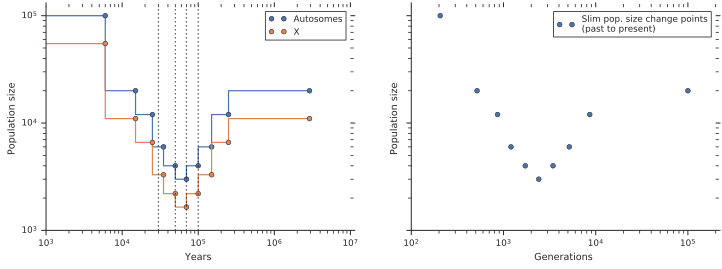

In [9]:
with sns.axes_style('ticks'):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), sharey=True)

    y = Series(list(reversed(changes_year)))
    n = Series(list(reversed(changes_Ne)))
    x = [j for i in zip(y.shift(), y) for j in i]
    y = [j for i in zip(n, n) for j in i]
    x[0] = 1000

    auto_demography = list(zip(reversed(x[1::2]), reversed(y[1::2])))

    color=next(ax1._get_lines.prop_cycler)['color']
    ax1.loglog(x, y, color=color)
    ax1.loglog(*list(zip(*auto_demography)), marker='o', color=color, linestyle='None', label='Autosomes');


    y = Series(list(reversed(changes_year)))
    n = Series(list(reversed(changes_Ne))) * x_auto_fraction
    x = [j for i in zip(y.shift(), y) for j in i]
    y = [j for i in zip(n, n) for j in i]
    x[0] = 1000

    x_demography = [(y, n*x_auto_fraction) for (y, n) in auto_demography]

    color=next(ax1._get_lines.prop_cycler)['color']
    ax1.loglog(x, y, color=color)
    ax1.loglog(*list(zip(*x_demography)), marker='o', color=color, linestyle='None', label='X');
    ax1.set_ylim(1000, 120000)
    ax1.set_xlim(1e3, 1e7) ;
    ax1.set_xlabel('Years')
    ax1.set_ylabel('Population size')
    ax1.legend()

    [ax1.axvline(x, linestyle='dotted', color='black') for x in sweep_years]
    
    
    
    slim_demography = [(years2gen(y), int(n)) for (y, n) in auto_demography]  ## using auto
    g, n = list(zip(*slim_demography))
    ax2.loglog([sim_generations-x for x in g], n, marker='o', linestyle='None', 
               label='Slim pop. size change points\n(past to present)');
    ax2.set_ylim(1000, 120000)
    ax2.set_xlim(1e2, 2e5) ;
    ax2.set_xlabel('Generations')
    ax2.set_ylabel('Population size')
    ax2.legend()

    sns.despine()


We use **autosomal** sizes for Slim because it models the X chrom explicitly. To make the X/A ratio lower than 0.75 we scale the population sizes by (e.g. 0.55/0.75) when running the slim simulation.

Generation-Ne pairs for changeing population size in Slim simulation (for adding to `workflow.py`):

In [10]:
slim_demography

[(1, 20000),
 (91379, 12000),
 (94827, 6000),
 (96551, 4000),
 (97586, 3000),
 (98275, 4000),
 (98793, 6000),
 (99137, 12000),
 (99482, 20000),
 (99793, 100000)]

Generations for sweeps in Slim simulations (for adding to `workflow.py`):

In [11]:
sweep_generations = [years2gen(x) for x in sweep_years]
sweep_generations

[98965, 98275, 97586, 96551]

In [12]:
# sim_generations = 100000

# def years2gen(y):
#     return int(sim_generations - y / 29)
    
    
# def demography(pop_size, bottle_pop_size, bottle_start, bottle_end):
    
#     def bottleneck_N(t):
#         return int(round(t / (1/bottle_pop_size - (1-t)/pop_size)))

#     t = Series([1, 2/3, 1/3])
#     demog = DataFrame(dict(bottle_pop_size=t.map(bottleneck_N), 
#                                    bottle_time=t*(bottle_start - bottle_end)))
#     demog['bottle_start'] = round(bottle_start - (bottle_start - bottle_end - demog.bottle_time) / 2).astype(int)
#     demog['bottle_end'] = round(bottle_end + (bottle_start - bottle_end - demog.bottle_time) / 2).astype(int)
#     demog['pop_size'] = pop_size
#     return demog

# smallest_x_auto_fraction = 0.5
# pop_size = int(20000 * smallest_x_auto_fraction)
# bottle_pop_size = int(2000 * smallest_x_auto_fraction)
# bottle_start = 100000
# bottle_end = 30000

# demog = pd.concat([demography(10000, 1000, 100000, 30000),
#                   # demography(20000, 2000, 100000, 30000)
#                   ])
# demog

Print for loading into `workflow.py`:

In [13]:
# list(zip(
#     list(demog.pop_size),
#     list(years2gen(x) for x in demog.bottle_start),
#     list(years2gen(x) for x in demog.bottle_end),
#     demog.bottle_pop_size))

## Load data for sweeps called on simulations

In [14]:
prop_swept_data = pd.read_hdf(str(ag.steps_dir / 'slim' / 'slim_summary.hdf'))
prop_swept_data['prop_swept'] = prop_swept_data.nr_swept / prop_swept_data.total

records = list()
for demog, sweep_type, sweep_start in prop_swept_data.simulation.str.split('_'):
    records.append([demog, sweep_type, int(sweep_start)])

df = pd.DataFrame.from_records(records, 
                      columns=['sweep_type', 'demography', 'sweep_start'], 
                              )

# df = pd.DataFrame.from_records(records, 
#                       columns=['sweep_type', 'N', 'bottle_start', 'bottle_end', 'bottle_width', 'sweep_start'], 
#                               )
# df['bottle_width'] = df.bottle_end - df.bottle_start
prop_swept_data = prop_swept_data.merge(df, left_index=True, right_index=True)
prop_swept_data.head()

FileNotFoundError: File /home/kmt/simons/faststorage/people/kmt/steps/slim/slim_summary.hdf does not exist

In [19]:
def facet_plot(start, end, prop_swept, **kwargs):
    x = [j for i in zip(start, end) for j in i]
    y = [j for i in zip(prop_swept, prop_swept) for j in i]      
    plt.plot(x, y, color='black', linewidth=0.2)
#    plt.plot(x, y, linewidth=0.2, **kwargs)
    plt.ylim((0, 1.1))
#    plt.fill_between(x, 0, y, color='gray', alpha=0.05)


with sns.axes_style('whitegrid'):
#     g = sns.FacetGrid(prop_swept_data, col='simulation', row='selection_coef', 
    g = sns.FacetGrid(prop_swept_data, col='selection_coef', row='simulation', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     size=2)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles



In [9]:
with sns.axes_style('whitegrid'):
#     g = sns.FacetGrid(prop_swept_data, col='simulation', row='selection_coef', 
    g = sns.FacetGrid(prop_swept_data.loc[prop_swept_data.simulation.str.startswith('nosweep')],
                      col='selection_coef', row='simulation', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     size=2)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles



In [11]:
prop_swept_data.simulation.unique()

array(['complete_10000_96551_98965_1000_99310',
       'complete_10000_96551_98965_10000_96206',
       'nosweep_10000_96551_98965_10000_96206',
       'complete_10000_96551_98965_1000_96206',
       'nosweep_10000_96954_98563_690_99310',
       'nosweep_10000_96551_98965_1000_96206',
       'complete_10000_97356_98160_357_99310',
       'partial_10000_97356_98160_357_99310',
       'complete_10000_97356_98160_357_98275',
       'complete_10000_96954_98563_690_98275',
       'nosweep_10000_96551_98965_1000_99310',
       'partial_10000_97356_98160_357_96206',
       'partial_10000_96954_98563_690_96206',
       'nosweep_10000_96551_98965_1000_98275',
       'partial_10000_96551_98965_10000_96206',
       'complete_10000_96954_98563_690_96206',
       'complete_10000_96551_98965_10000_98275',
       'partial_10000_96954_98563_690_98275',
       'complete_10000_97356_98160_357_96206',
       'complete_10000_96954_98563_690_99310',
       'nosweep_10000_96551_98965_10000_98275',
       'n

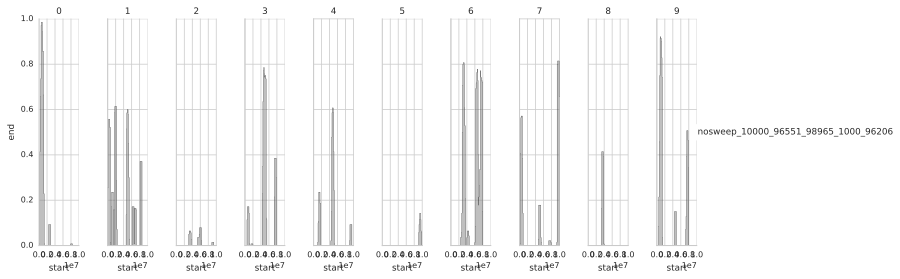

In [18]:
def facet_plot(start, end, prop_swept, **kwargs):
    x = [j for i in zip(start, end) for j in i]
    y = [j for i in zip(prop_swept, prop_swept) for j in i]      
    plt.plot(x, y, color='black', linewidth=0.2)
#    plt.plot(x, y, linewidth=0.2, **kwargs)
    plt.ylim((0, 1))
    plt.fill_between(x, 0, y, color='gray', alpha=0.5)

with sns.axes_style('whitegrid'):
#     g = sns.FacetGrid(prop_swept_data, col='simulation', row='selection_coef', 
    g = sns.FacetGrid(prop_swept_data.loc[prop_swept_data.simulation.isin(['nosweep_10000_96551_98965_1000_96206',
                                                                           '']) &\
                                           (prop_swept_data.selection_coef == 0.01)],
                      col='replication', row='simulation', sharex=True, sharey=True, margin_titles=True,
                     size=4, aspect=0.25)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles



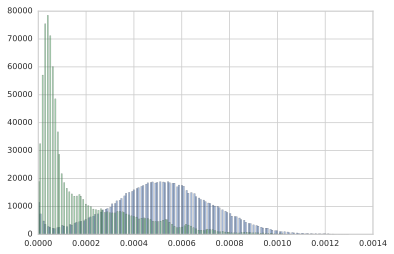

In [16]:
s = 'nosweep_10000_96551_98965_10000_96206_{}'.format(20)
f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
df = pd.read_hdf(f_name_tmpl.format(0))
plt.hist(df.dist, bins=200, alpha=0.5) ;

s = 'nosweep_10000_96551_98965_1000_96206_{}'.format(20)
f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
df = pd.read_hdf(f_name_tmpl.format(0))
plt.hist(df.dist, bins=200, alpha=0.5) ;


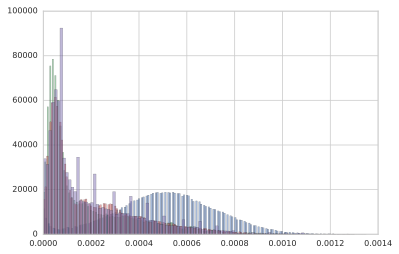

In [20]:
s = 'nosweep_10000_96551_98965_10000_96206_{}'.format(20)
f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
df = pd.read_hdf(f_name_tmpl.format(0))
plt.hist(df.dist, bins=200, alpha=0.5) ;

s = 'nosweep_10000_96551_98965_1000_96206_{}'.format(20)
f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
df = pd.read_hdf(f_name_tmpl.format(0))
plt.hist(df.dist, bins=200, alpha=0.5) ;

s = 'nosweep_10000_96954_98563_690_98275_{}'.format(20)
f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
df = pd.read_hdf(f_name_tmpl.format(0))
plt.hist(df.dist, bins=200, alpha=0.5) ;

s = 'nosweep_10000_97356_98160_357_99310_{}'.format(20)
f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
df = pd.read_hdf(f_name_tmpl.format(0))
plt.hist(df.dist, bins=100, alpha=0.5) ;


In [ ]:


s = 'nosweep_10000_3448_5861_10000_5171_{}'.format(20)
f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
df = pd.read_hdf(f_name_tmpl.format(0))
plt.hist(df.dist, bins=100, alpha=0.5) ;


In [ ]:
s = 'nosweep_10000_3447_5861_1000_3102_{}'.format(20)
f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
df = pd.read_hdf(f_name_tmpl.format(0))
plt.hist(df.dist, bins=200, alpha=0.5) ;

s = 'nosweep_10000_3448_5861_10000_3102_{}'.format(20)
f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
df = pd.read_hdf(f_name_tmpl.format(0))
plt.hist(df.dist, bins=200, alpha=0.5) ;


In [ ]:
s = 'nosweep_10000_3447_5861_1000_3102_{}'.format(20)
f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
df = pd.read_hdf(f_name_tmpl.format(0))
plt.hist(df.dist, bins=100) ;

In [ ]:
plt.figure(figsize=(10,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    df = pd.read_hdf(f_name_tmpl.format(i))
    plt.hist(df.dist, bins=100)
    plt.axvline(5e-5, color='orange', zorder=0)

In [ ]:
import pyslim, msprime, random
seed = 7
mutation_rate = 1.25e-8
sample_size = 100

trees = pyslim.load(f_name_tmpl.format(0).replace('.hdf', '.trees'))

# Overlay neutral mutations and make bit arrays for each SNP:
sample_ids = sorted(random.sample(list(trees.samples()), sample_size))

trees_sample = trees.simplify(samples=sample_ids, filter_zero_mutation_sites=True, filter_individuals=True)
mutated_trees = msprime.mutate(trees_sample, rate=mutation_rate, random_seed=seed)
# mutated.dump("./sweep_overlaid.trees") 
print(mutated_trees.pairwise_diversity() / mutated_trees.sequence_length)


ts = mutated_trees
# Measure the tree height at each base position
height_for_pos = np.zeros(int(ts.sequence_length))
for tree in ts.trees():
    mean_height = np.mean([tree.time(root) for root in tree.roots])
    left, right = map(int, tree.interval)
    height_for_pos[left: right] = mean_height
height_for_pos
plt.figure(figsize=(10,3))
plt.plot(height_for_pos, linewidth=0.5, color='black') ;


trees = pyslim.load(f_name_tmpl.format(1).replace('.hdf', '.trees'))

# Overlay neutral mutations and make bit arrays for each SNP:
sample_ids = sorted(random.sample(list(trees.samples()), sample_size))

trees_sample = trees.simplify(samples=sample_ids, filter_zero_mutation_sites=True, filter_individuals=True)
mutated_trees = msprime.mutate(trees_sample, rate=mutation_rate, random_seed=seed)
# mutated.dump("./sweep_overlaid.trees") 
print(mutated_trees.pairwise_diversity() / mutated_trees.sequence_length)


ts = mutated_trees
# Measure the tree height at each base position
height_for_pos = np.zeros(int(ts.sequence_length))
for tree in ts.trees():
    mean_height = np.mean([tree.time(root) for root in tree.roots])
    left, right = map(int, tree.interval)
    height_for_pos[left: right] = mean_height
height_for_pos

plt.plot(height_for_pos, linewidth=0.5, color='red') ;







## Run slim testing to get pairwise distances for testing purposes

In [107]:
from itertools import combinations
import argparse
import random
import subprocess
import re, os, sys
import tempfile
import numpy as np
import pandas as pd
from pandas import DataFrame
import msprime, pyslim

trees_file = "/home/kmt/simons/faststorage/people/kmt/test_slim.trees"

slurm_script = r'''
initialize() {
	initializeTreeSeq();
	initializeMutationRate(0);
	initializeMutationType("m1", 0.5, "f", 0.0);
	initializeGenomicElementType("g1", m1, 1.0);
	initializeGenomicElement(g1, 0, 10e6-1);
	initializeRecombinationRate(1e-8);
}
1 {
	defineConstant("simID", getSeed());
	sim.addSubpop("p1", 10000);
}
50000 {
    sim.treeSeqOutput("OUTFILE");
	sim.simulationFinished();
}
'''.replace('OUTFILE', trees_file)

print(slurm_script)
random.seed(7)

window_size = 100000

# write slim script file with the right output name
slurm_script_file = tempfile.NamedTemporaryFile(mode='w', delete=False)
slurm_script_file.write(slurm_script)
slurm_script_file.close()

# run slim
cmd = '/home/kmt/simons/faststorage/people/kmt/slim {}'.format(slurm_script_file.name)
p = subprocess.Popen(cmd.split(), 
    stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = p.communicate()
print(stdout.decode())
print(stderr.decode())


initialize() {
	initializeTreeSeq();
	initializeMutationRate(0);
	initializeMutationType("m1", 0.5, "f", 0.0);
	initializeGenomicElementType("g1", m1, 1.0);
	initializeGenomicElement(g1, 0, 10e6-1);
	initializeRecombinationRate(1e-8);
}
1 {
	defineConstant("simID", getSeed());
	sim.addSubpop("p1", 10000);
}
50000 {
    sim.treeSeqOutput("/home/kmt/simons/faststorage/people/kmt/test_slim.trees");
	sim.simulationFinished();
}

// Initial random seed:
1588181088081

// RunInitializeCallbacks():
initializeTreeSeq();
initializeMutationRate(0);
initializeMutationType(1, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 9999999);
initializeRecombinationRate(1e-08);

// Starting run at generation <start>:
1 





In [129]:
mutationrate = 4.3e-10
generationtime = 29

# load trees from slim
ts = pyslim.load(trees_file)

# overlay mutations
mutated_ts = msprime.mutate(ts, rate=mutationrate*generationtime, random_seed=2, keep=True)

2631.1430615333334

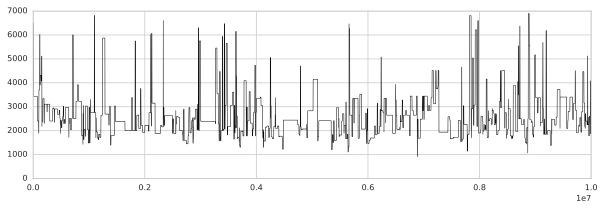

In [131]:
ts = mutated_trees
# Measure the tree height at each base position
height_for_pos = np.zeros(int(ts.sequence_length))
for tree in ts.trees():
    mean_height = np.mean([tree.time(root) for root in tree.roots])
    left, right = map(int, tree.interval)
    height_for_pos[left: right] = mean_height
height_for_pos
plt.figure(figsize=(10,3))
plt.plot(height_for_pos, linewidth=0.5, color='black') ;

height_for_pos.mean()

In [114]:
samples = 10

# random indexes for samples
sample_idx = set(random.sample(range(ts.num_individuals), samples))
assert len(sample_idx) == samples

In [115]:
# get the corresponding sample haplotypes
sample = list()
for i, hap in enumerate(mutated_ts.haplotypes()):
    if i in sample_idx:
        sample.append(hap)        

In [117]:
        
# get the positions of each segregating site
positions = [site.position for site in mutated_ts.sites()]  

# make table with sampled haplotypes
table = np.array([list(map(np.int8, hap)) for hap in sample]).transpose()

In [118]:
# turn table into dataframe with positions
df = DataFrame(table, dtype='int8')
df['pos'] = positions

0  1  2  3  4  5  6  7  8  9         pos
0  0  0  0  0  0  0  0  0  0  0  205.002715
1  0  0  0  0  0  0  0  0  0  0  468.055892
2  0  0  0  0  0  0  0  0  0  0  475.586858
3  0  0  0  0  0  0  0  1  0  0  799.590830
4  1  0  1  0  0  1  0  0  1  1  813.534688

In [119]:
# add a row with zeros for the start of each window so there is at least
# one row in each window
zeros = dict((x, 0) for x in range(samples))
extra_df = pd.DataFrame({'pos': range(0, int(mutated_ts.sequence_length), window_size), **zeros})
df = df.append(extra_df)

0  1  2  3  4  5  6  7  8  9        pos
95  0  0  0  0  0  0  0  0  0  0  9500000.0
96  0  0  0  0  0  0  0  0  0  0  9600000.0
97  0  0  0  0  0  0  0  0  0  0  9700000.0
98  0  0  0  0  0  0  0  0  0  0  9800000.0
99  0  0  0  0  0  0  0  0  0  0  9900000.0

In [120]:
# make a start column grouping all rows in same window
df['start'] = ((df.pos // window_size) * window_size).astype('uint32')
df.drop('pos', axis=1, inplace=True)
df.set_index('start', inplace=True)

def pw_dist(df):
    "computes differences bewteen all pairs in a window"
    pairs = list(combinations(df.columns, 2))
    site_diffs = [np.bitwise_xor(df[p[0]], df[p[1]]) for p in pairs]
    return pd.concat(site_diffs, axis=1, keys=pairs).sum()

# make a dataframe with distance for each pair
pw_dist_df = (
    df
    .groupby('start')
    .apply(pw_dist)
    .reset_index()
    .melt(id_vars=['start'], var_name=['indiv_1', 'indiv_2'], value_name='dist')
    )

start indiv_1 indiv_2  dist
0       0       0       1    74
1  100000       0       1    67
2  200000       0       1    57
3  300000       0       1    61
4  400000       0       1    34

In [121]:
# compute proper distance as number of diffs divided by window size
pw_dist_df['dist'] /= window_size

# add end column
pw_dist_df.insert(loc=1, column='end', value=pw_dist_df.start + window_size)

# convert indiv labels from object to int and and write hdf
pw_dist_df['indiv_1'] = pw_dist_df['indiv_1'].astype('uint16')
pw_dist_df['indiv_2'] = pw_dist_df['indiv_2'].astype('uint16')
#pw_dist_df.to_hdf(args.hdf_file, 'df', format='table', mode='w')

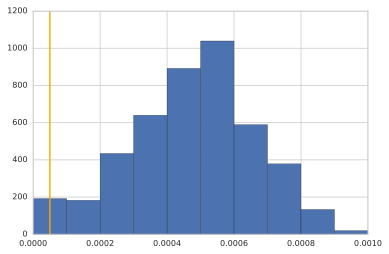

In [127]:
plt.hist(pw_dist_df.dist) 
plt.axvline(5e-5, color='orange') ;